# Análisis Empírico: Algoritmo Eficiente vs Fuerza Bruta

## Objetivos:
1. Comparar calidad de solución (eficiente vs óptima)
2. Analizar tiempos de ejecución
3. Determinar límite resolutivo de fuerza bruta

## Configuración inicial y librerías

In [4]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Añadir src al path para importar módulos
sys.path.append('../..')
sys.path.append('../')

output_path = Path.cwd() / "results"
output_path.mkdir(exist_ok=True)

# Importar generador y algoritmos
from src.tester.generator import generate_random_instance
from src.solutions.brute_force_JAT import solve as solve_brute_force 
from src.solutions.efficient import solve as solve_efficient

## Clase para experimentación

In [5]:
class ExperimentRunner:
    def __init__(self):
        self.results = []
        
    def run_single_experiment(self, num_ports, num_items, seed=None):
        """Ejecuta un experimento individual"""
        
        # Generar instancia
        instance = generate_random_instance(
            min_ports=num_ports,
            max_ports=num_ports,
            min_items=num_items,
            max_items=num_items,
            seed=seed
        )
        
        # Solo 3 líneas de código para ejecutar con timeout
        ejecutor = ThreadPoolExecutor()
        futuro = ejecutor.submit(solve_brute_force, *instance)
        timeout = False
        
        try:
            start = time.time()
            brute_result = futuro.result(timeout=60)
            brute_time = time.time() - start
        except TimeoutError:
            futuro.cancel()
            timeout = True            
        ejecutor.shutdown(wait=False)
                
        # Medir tiempo y ejecutar algoritmo eficiente
        start = time.time()
        efficient_result = solve_efficient(*instance)
        efficient_time = time.time() - start
        
        if timeout:
            return {
                'num_ports': num_ports,
                'num_items': num_items,
                'seed': seed,
                'brute_time': 60,
                'efficient_time': efficient_time,
                'brute_value': None,
                'efficient_value': efficient_result,
                'quality_ratio': None,
                'time_ratio': 60 / efficient_time if efficient_time > 0 else float('inf'),
                'is_optimal': False,
                'instance_size': num_ports * num_items,
                'timeout': True
            }
        
        # Calcular calidad relativa
        if brute_result != 0:
            quality_ratio = (efficient_result / brute_result) * 100
        else:
            quality_ratio = 100 if efficient_result == 0 else float('inf')
        
        return {
            'num_ports': num_ports,
            'num_items': num_items,
            'seed': seed,
            'brute_time': brute_time,
            'efficient_time': efficient_time,
            'brute_value': brute_result,
            'efficient_value': efficient_result,
            'quality_ratio': quality_ratio,
            'time_ratio': brute_time / efficient_time if efficient_time > 0 else float('inf'),
            'is_optimal': efficient_result == brute_result,
            'instance_size': num_ports * num_items,
            'timeout': False
        }
    
    def run_experiment_batch(self, num_ports_list, num_items_list, repetitions=30, timeout=300):
        """Ejecuta un batch de experimentos con timeout"""
        
        results = []
        total_experiments = len(num_ports_list) * len(num_items_list) * repetitions
        
        with tqdm(total=total_experiments, desc="Ejecutando experimentos") as pbar:
            for num_ports in num_ports_list:
                for num_items in num_items_list:
                    for rep in range(repetitions):
                        seed = num_ports * 1000 + num_items * 100 + rep
                        
                        try:
                            result = self.run_single_experiment(num_ports, num_items, seed)                            
                            results.append(result)
                        except Exception as e:
                            print(f"Error en {num_ports} puertos, {num_items} items: {e}")
                        
                        pbar.update(1)
        
        self.results = pd.DataFrame(results)
        return self.results

In [6]:
# Configurar experimentos
runner = ExperimentRunner()

## Experimento 1: Escalabilidad en número de ítems (puertos fijos)

In [8]:
# Rango de parámetros
num_ports_fixed = 3
num_items_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]
repetitions = 30

# Ejecutar experimentos
results_fixed_ports = runner.run_experiment_batch(
    num_ports_list=[num_ports_fixed],
    num_items_list=num_items_range,
    repetitions=repetitions
)

Ejecutando experimentos:   0%|          | 0/270 [00:00<?, ?it/s]

Ejecutando experimentos: 100%|██████████| 270/270 [00:56<00:00,  4.80it/s]


### Análisis estadístico para puertos fijos

In [9]:
# Calcular estadísticas por número de ítems
stats_by_items = results_fixed_ports.groupby('num_items').agg({
    'quality_ratio': ['mean', 'std', 'min', 'max'],
    'brute_time': ['mean', 'std', 'max'],
    'efficient_time': ['mean', 'std', 'max'],
    'is_optimal': 'mean'
}).round(3)

print("Estadísticas por número de ítems (3 puertos):")
print(stats_by_items)

Estadísticas por número de ítems (3 puertos):
          quality_ratio                        brute_time                \
                   mean     std     min    max       mean    std    max   
num_items                                                                 
2                96.422   9.085  58.348  100.0      0.000  0.000  0.000   
3                97.796   6.985  66.404  100.0      0.000  0.000  0.000   
4                89.854  11.978  63.388  100.0      0.006  0.025  0.136   
5                91.213  14.329  57.843  100.0      0.004  0.012  0.061   
6                89.243  15.855  50.579  100.0      0.015  0.050  0.261   
7                78.918  16.748  35.342  100.0      0.195  0.383  1.491   
8                75.983  19.880  36.177  100.0      0.092  0.218  0.732   
9                73.268  17.166  38.641  100.0      0.538  1.180  4.655   
10               71.997  17.703  33.370  100.0      0.815  1.475  6.374   

          efficient_time               is_optimal  
 

### Visualizaciones para Experimentos con Puertos Fijos

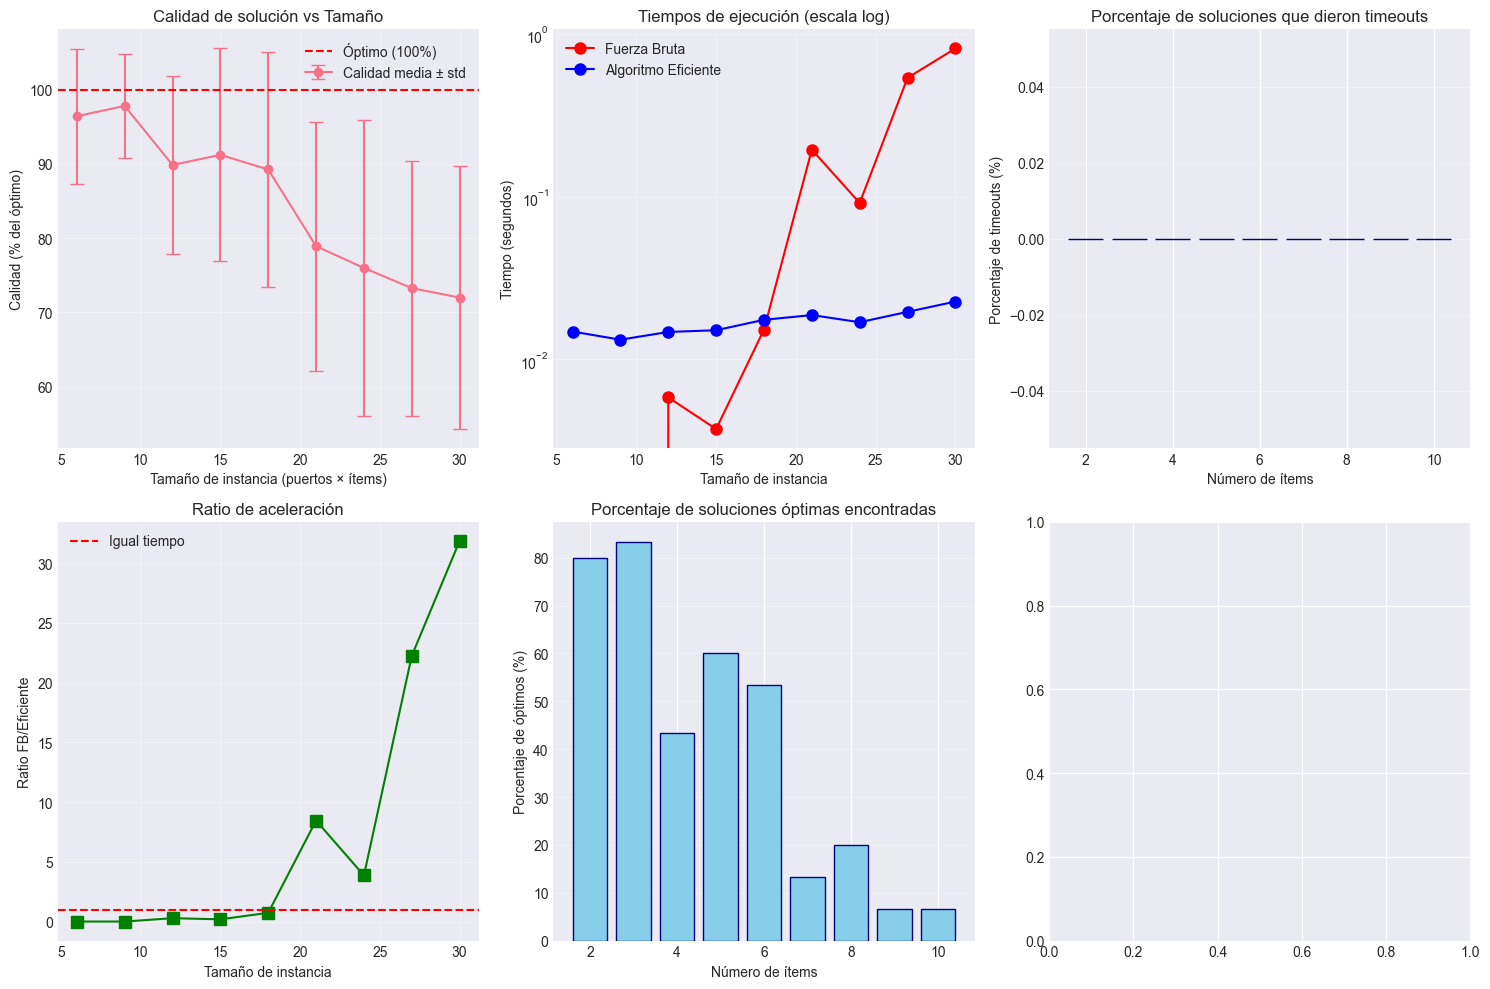

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Calidad de solución vs tamaño de instancia
ax = axes[0, 0]
quality_data = results_fixed_ports.groupby('instance_size')['quality_ratio'].agg(['mean', 'std'])
ax.errorbar(quality_data.index, quality_data['mean'], yerr=quality_data['std'], 
           fmt='o-', capsize=5, label='Calidad media ± std')
ax.axhline(y=100, color='r', linestyle='--', label='Óptimo (100%)')
ax.set_xlabel('Tamaño de instancia (puertos × ítems)')
ax.set_ylabel('Calidad (% del óptimo)')
ax.set_title('Calidad de solución vs Tamaño')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Tiempos de ejecución (log scale)
ax = axes[0, 1]
for algorithm, color, label in [('brute_time', 'red', 'Fuerza Bruta'), 
                                ('efficient_time', 'blue', 'Algoritmo Eficiente')]:
    time_data = results_fixed_ports.groupby('instance_size')[algorithm].mean()
    ax.plot(time_data.index, time_data, 'o-', color=color, label=label, markersize=8)
ax.set_xlabel('Tamaño de instancia')
ax.set_ylabel('Tiempo (segundos)')
ax.set_yscale('log')
ax.set_title('Tiempos de ejecución (escala log)')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Ratio de tiempo (Fuerza Bruta / Eficiente)
ax = axes[1, 0]
time_ratio_data = results_fixed_ports.groupby('instance_size')['time_ratio'].mean()
ax.plot(time_ratio_data.index, time_ratio_data, 's-', color='green', markersize=8)
ax.axhline(y=1, color='r', linestyle='--', label='Igual tiempo')
ax.set_xlabel('Tamaño de instancia')
ax.set_ylabel('Ratio FB/Eficiente')
ax.set_title('Ratio de aceleración')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Porcentaje de soluciones óptimas encontradas
ax = axes[1, 1]
optimal_rate = results_fixed_ports.groupby('num_items')['is_optimal'].mean() * 100
ax.bar(optimal_rate.index, optimal_rate.values, color='skyblue', edgecolor='navy')
ax.set_xlabel('Número de ítems')
ax.set_ylabel('Porcentaje de óptimos (%)')
ax.set_title('Porcentaje de soluciones óptimas encontradas')
ax.grid(True, alpha=0.3, axis='y')

# 5. Porcentaje de soluciones que dieron timeout
ax = axes[0, 2]
timeouts = results_fixed_ports.groupby('num_items')['timeout']
if timeouts:
    optimal_rate = timeouts.mean() * 100
    ax.bar(optimal_rate.index, optimal_rate.values, color='skyblue', edgecolor='navy')
    ax.set_xlabel('Número de ítems')
    ax.set_ylabel('Porcentaje de timeouts (%)')
    ax.set_title('Porcentaje de soluciones que dieron timeouts')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{output_path}/analisis_puertos_fijos.png', dpi=300, bbox_inches='tight')
plt.show()

## Experimento 2: Escalabilidad en número de puertos (ítems fijos)

In [11]:
# Configurar segundo experimento
num_items_fixed = 4
num_ports_range = [3, 4, 5, 6, 7, 8]

results_fixed_items = runner.run_experiment_batch(
    num_ports_list=num_ports_range,
    num_items_list=[num_items_fixed],
    repetitions=repetitions
)

Ejecutando experimentos: 100%|██████████| 180/180 [11:51<00:00,  3.95s/it]


In [14]:
# Calcular estadísticas por número de ítems
stats_by_ports = results_fixed_items.groupby('num_ports').agg({
    'quality_ratio': ['mean', 'std', 'min', 'max'],
    'brute_time': ['mean', 'std', 'max'],
    'efficient_time': ['mean', 'std', 'max'],
    'is_optimal': 'mean'
}).round(3)

print("Estadísticas por número de puertos (4 items):")
print(stats_by_ports)

Estadísticas por número de puertos (4 items):
          quality_ratio                        brute_time                  \
                   mean     std     min    max       mean     std     max   
num_ports                                                                   
3                89.854  11.978  63.388  100.0      0.005   0.026   0.144   
4                86.969  17.714  46.821  100.0      0.055   0.278   1.523   
5                85.068  19.607  39.008  100.0      0.536   2.004  10.545   
6                82.775  16.341  47.707  100.0      2.185  10.934  60.000   
7                87.637  14.868  48.904  100.0      4.538  15.344  60.000   
8                81.662  22.145   5.916  100.0     15.382  24.655  60.000   

          efficient_time               is_optimal  
                    mean    std    max       mean  
num_ports                                          
3                  0.016  0.005  0.029      0.433  
4                  0.015  0.005  0.024      0.500  


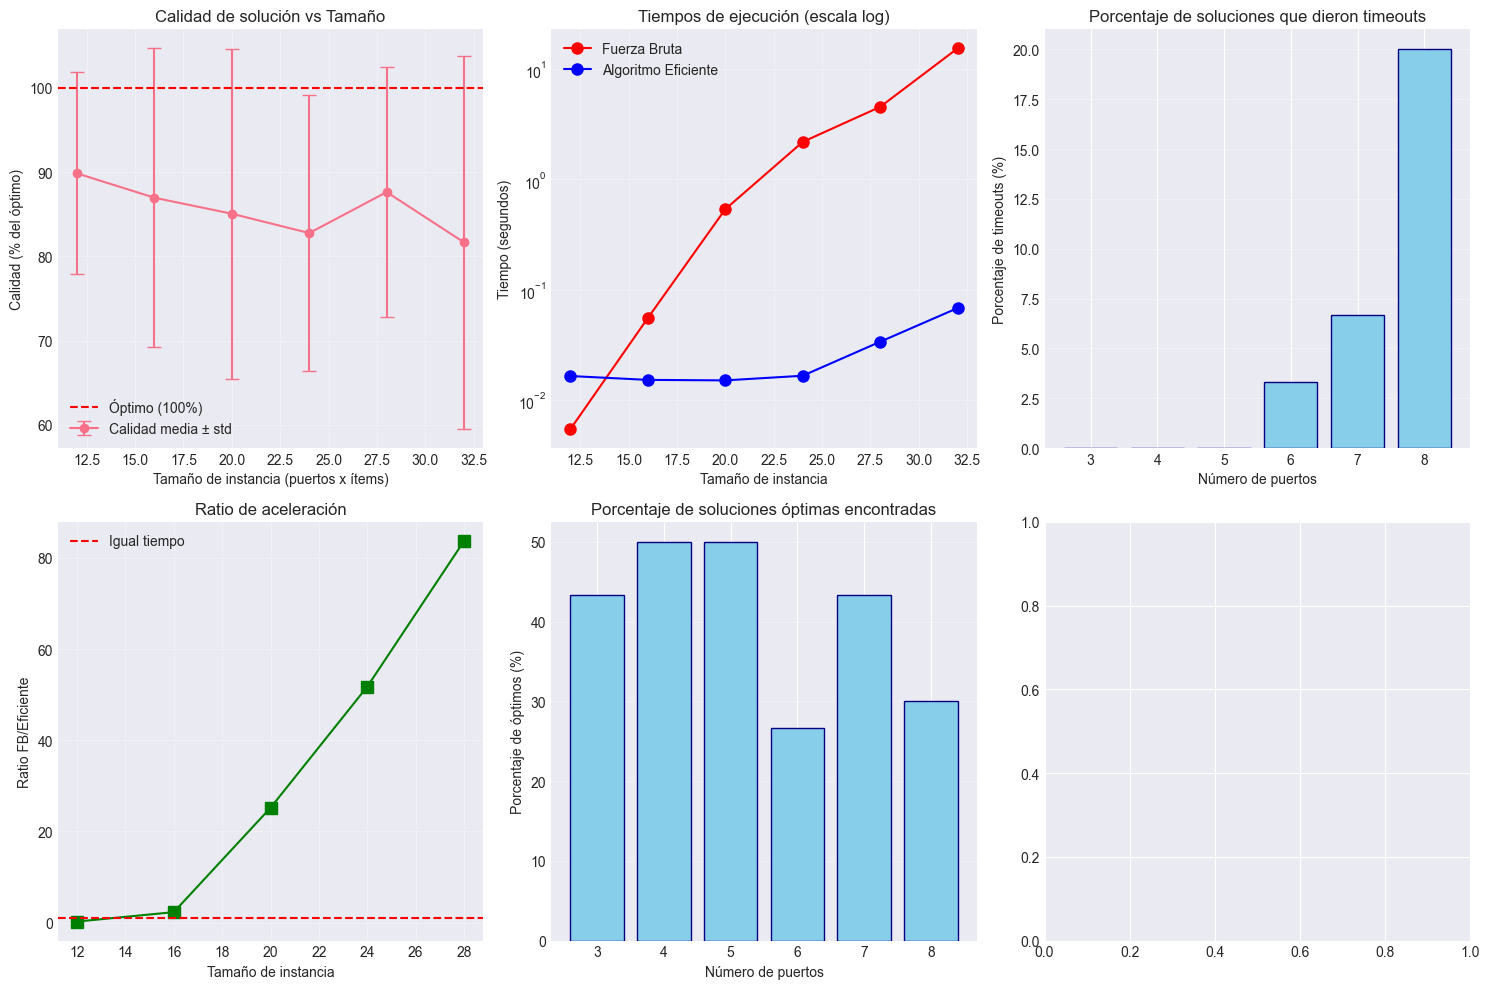

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Calidad de solución vs tamaño de instancia
ax = axes[0, 0]
quality_data = results_fixed_items.groupby('instance_size')['quality_ratio'].agg(['mean', 'std'])
ax.errorbar(quality_data.index, quality_data['mean'], yerr=quality_data['std'], 
           fmt='o-', capsize=5, label='Calidad media ± std')
ax.axhline(y=100, color='r', linestyle='--', label='Óptimo (100%)')
ax.set_xlabel('Tamaño de instancia (puertos x ítems)')
ax.set_ylabel('Calidad (% del óptimo)')
ax.set_title('Calidad de solución vs Tamaño')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Tiempos de ejecución (log scale)
ax = axes[0, 1]
for algorithm, color, label in [('brute_time', 'red', 'Fuerza Bruta'), 
                                ('efficient_time', 'blue', 'Algoritmo Eficiente')]:
    time_data = results_fixed_items.groupby('instance_size')[algorithm].mean()
    ax.plot(time_data.index, time_data, 'o-', color=color, label=label, markersize=8)
ax.set_xlabel('Tamaño de instancia')
ax.set_ylabel('Tiempo (segundos)')
ax.set_yscale('log')
ax.set_title('Tiempos de ejecución (escala log)')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Ratio de tiempo (Fuerza Bruta / Eficiente)
ax = axes[1, 0]
time_ratio_data = results_fixed_items.groupby('instance_size')['time_ratio'].mean()
ax.plot(time_ratio_data.index, time_ratio_data, 's-', color='green', markersize=8)
ax.axhline(y=1, color='r', linestyle='--', label='Igual tiempo')
ax.set_xlabel('Tamaño de instancia')
ax.set_ylabel('Ratio FB/Eficiente')
ax.set_title('Ratio de aceleración')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Porcentaje de soluciones óptimas encontradas
ax = axes[1, 1]
optimal_rate = results_fixed_items.groupby('num_ports')['is_optimal'].mean() * 100
ax.bar(optimal_rate.index, optimal_rate.values, color='skyblue', edgecolor='navy')
ax.set_xlabel('Número de puertos')
ax.set_ylabel('Porcentaje de óptimos (%)')
ax.set_title('Porcentaje de soluciones óptimas encontradas')
ax.grid(True, alpha=0.3, axis='y')

# 5. Porcentaje de soluciones que dieron timeout
ax = axes[0, 2]
timeouts = results_fixed_items.groupby('num_ports')['timeout']
if timeouts:
    optimal_rate = timeouts.mean() * 100
    ax.bar(optimal_rate.index, optimal_rate.values, color='skyblue', edgecolor='navy')
    ax.set_xlabel('Número de puertos')
    ax.set_ylabel('Porcentaje de timeouts (%)')
    ax.set_title('Porcentaje de soluciones que dieron timeouts')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{output_path}/analisis_items_fijos.png', dpi=300, bbox_inches='tight')
plt.show()

## Experimento 3: Análisis de casos límite

In [16]:
def analyze_hard_instances(results_df, threshold=95):
    """Identifica instancias donde el algoritmo funciona peor"""
    
    # Instancias con calidad inferior al threshold
    hard_instances = results_df[results_df['quality_ratio'] < threshold].copy()
    
    if len(hard_instances) > 0:
        print(f"\n=== INSTANCIAS DIFÍCILES (calidad < {threshold}%) ===")
        print(f"Total encontradas: {len(hard_instances)}")
        
        # Características de instancias difíciles
        print("\nCaracterísticas promedio de instancias difíciles:")
        print(hard_instances[['num_ports', 'num_items', 'instance_size', 'quality_ratio']].mean())
        
        # Comparar con el promedio general
        print("\nComparación con promedio general:")
        general_avg = results_df[['num_ports', 'num_items', 'instance_size', 'quality_ratio']].mean()
        comparison = pd.DataFrame({
            'General': general_avg,
            'Díficiles': hard_instances[['num_ports', 'num_items', 'instance_size', 'quality_ratio']].mean()
        })
        print(comparison)
    
    return hard_instances

# Ejecutar análisis
combined_results = pd.concat([results_fixed_ports, results_fixed_items])
hard_instances = analyze_hard_instances(combined_results, threshold=95)


=== INSTANCIAS DIFÍCILES (calidad < 95%) ===
Total encontradas: 233

Características promedio de instancias difíciles:
num_ports         3.957082
num_items         6.004292
instance_size    21.841202
quality_ratio    72.406136
dtype: float64

Comparación con promedio general:
                 General  Díficiles
num_ports       4.000000   3.957082
num_items       5.200000   6.004292
instance_size  19.600000  21.841202
quality_ratio  85.287449  72.406136


## Visualización avanzada: Superficie de respuesta

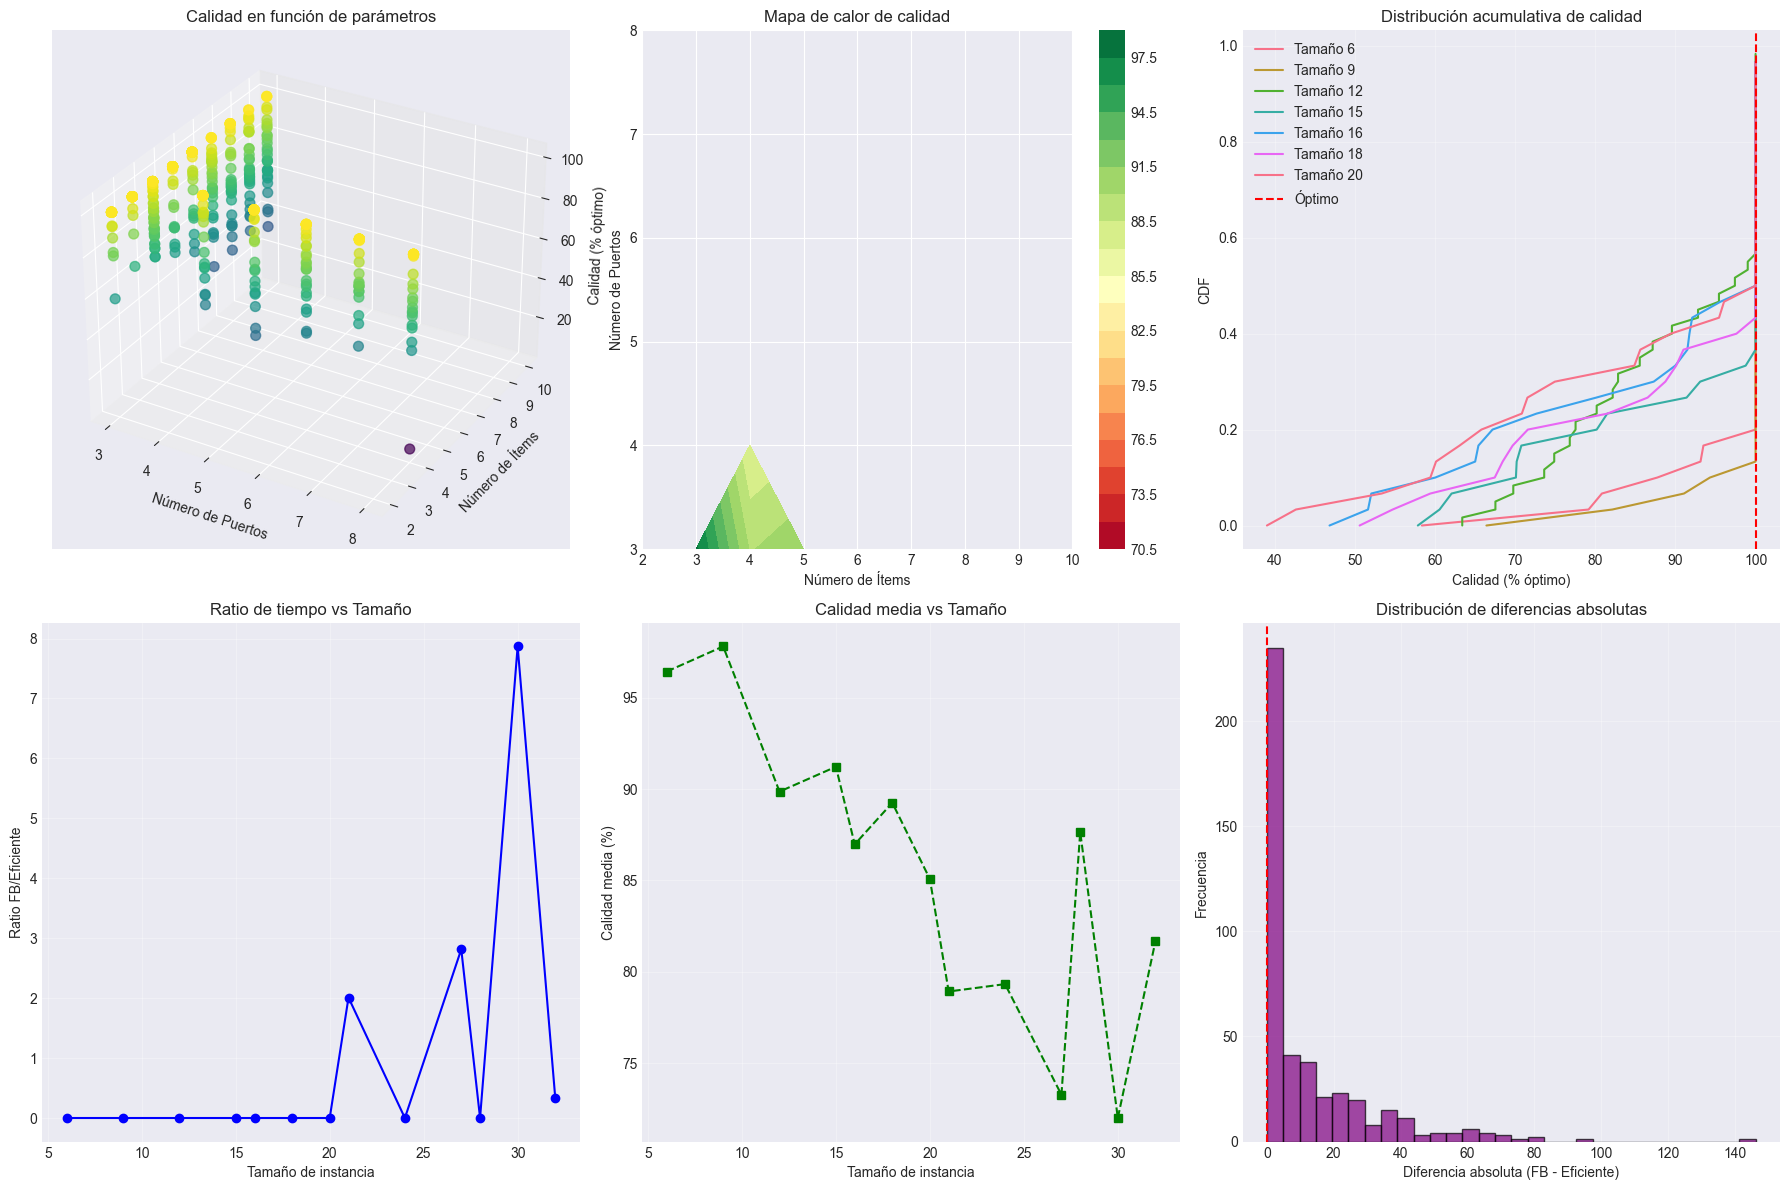

In [17]:
# Crear malla para superficie
fig = plt.figure(figsize=(18, 12))

# --- Gráfico 3D: Calidad en función de puertos e ítems ---
ax1 = fig.add_subplot(231, projection='3d')
scatter = ax1.scatter(combined_results['num_ports'], 
                     combined_results['num_items'], 
                     combined_results['quality_ratio'],
                     c=combined_results['quality_ratio'],
                     cmap='viridis',
                     s=50,
                     alpha=0.7)
ax1.set_xlabel('Número de Puertos')
ax1.set_ylabel('Número de Ítems')
ax1.set_zlabel('Calidad (% óptimo)')
ax1.set_title('Calidad en función de parámetros')

# --- Gráfico de contorno ---
ax3 = fig.add_subplot(232)
contour_data = combined_results.pivot_table(
    values='quality_ratio',
    index='num_ports',
    columns='num_items',
    aggfunc='mean'
)
contour = ax3.contourf(contour_data.columns, contour_data.index, contour_data.values, 
                      levels=20, cmap='RdYlGn')
plt.colorbar(contour, ax=ax3)
ax3.set_xlabel('Número de Ítems')
ax3.set_ylabel('Número de Puertos')
ax3.set_title('Mapa de calor de calidad')

# --- Distribución acumulativa de calidad ---
ax4 = fig.add_subplot(233)
for size in sorted(combined_results['instance_size'].unique()):
    if size <= 20:
        subset = combined_results[combined_results['instance_size'] == size]['quality_ratio']
        if len(subset) > 0:
            sorted_data = np.sort(subset.dropna())
            yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
            ax4.plot(sorted_data, yvals, label=f'Tamaño {size}')

ax4.axvline(x=100, color='r', linestyle='--', label='Óptimo')
ax4.set_xlabel('Calidad (% óptimo)')
ax4.set_ylabel('CDF')
ax4.set_title('Distribución acumulativa de calidad')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# --- Ratio de tiempos por tamaño (gráfico separado) ---
ax5 = fig.add_subplot(234)
size_groups = combined_results.groupby('instance_size')
sizes = []
time_ratios = []
quality_means = []

for size, group in size_groups:
    if len(group) >= 5:  # Solo tamaños con suficientes datos
        sizes.append(size)
        time_ratios.append(group['time_ratio'].median())
        quality_means.append(group['quality_ratio'].mean())

ax5.plot(sizes, time_ratios, 'o-', color='blue')
ax5.set_xlabel('Tamaño de instancia')
ax5.set_ylabel('Ratio FB/Eficiente')
ax5.set_title('Ratio de tiempo vs Tamaño')
ax5.grid(True, alpha=0.3)

# --- Calidad media por tamaño (gráfico separado) ---
ax6 = fig.add_subplot(235)
ax6.plot(sizes, quality_means, 's--', color='green')
ax6.set_xlabel('Tamaño de instancia')
ax6.set_ylabel('Calidad media (%)')
ax6.set_title('Calidad media vs Tamaño')
ax6.grid(True, alpha=0.3)

# --- Histograma de diferencias absolutas ---
ax7 = fig.add_subplot(236)
differences = combined_results['brute_value'] - combined_results['efficient_value']
differences = differences.dropna()
ax7.hist(differences, bins=30, alpha=0.7, color='purple', edgecolor='black')
ax7.axvline(x=0, color='r', linestyle='--')
ax7.set_xlabel('Diferencia absoluta (FB - Eficiente)')
ax7.set_ylabel('Frecuencia')
ax7.set_title('Distribución de diferencias absolutas')
ax7.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_path}/analisis_completo_3d.png', dpi=300, bbox_inches='tight')
plt.show()
